# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Data/Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import deque
from dqn_agent import Agent
from model import QNetwork

In [6]:
# Tracking
!pip install wandb
!pip install jovian
!pip install tqdm


import wandb
from tqdm import tqdm
import jovian

In [7]:
from time import time
from functools import reduce

def secondsToStr(t):
    return "%d:%02d:%02d.%03d" % \
        reduce(lambda ll,b : divmod(ll[0],b) + ll[1:],
            [(t*1000,),1000,60,60])

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per epidodes
        eps_start (float): starting value of epsilon, for epsilon_greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    tq = tqdm()
    scores = []                              # list containing scores from each episode
    scores_window = deque(maxlen=100)      # last 100 scores
    eps = eps_start                          # initialize epsilon
    t0 = time()
    
    for i_episode in range (1, n_episodes + 1):
        tq.update(1)
        tq.set_description(f"Episode {i_episode}")
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)            # save most recent score
        scores.append(score)                   # save most recent score
        eps = max(eps_end, eps_decay*eps)
        wandb.log({'score': score,
                   'average score': np.mean(scores_window),
                   'epsilon': eps})
        ##print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}', end='')
        tq.set_postfix({'score':np.mean(scores_window)}, refresh=True)
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}')
        if np.mean(scores_window) >= 13.:
            print(f'\nEnvironment solved in {i_episode - 100} episodes!\tAverage Score: {np.mean(scores_window)}')
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            jovian.log_metrics({
                'average_score: ': np.mean(scores_window),
                'total episode:': i_episode ,
                'total time: ': secondsToStr(time() - t0)
            })
            jovian.commit(project=agent.get_project_name(), message=agent.get_model_name(), environment=None, 
                          files= ["dqn_agent.py", "replaybuffer.py", "model.py"], outputs=['checkpoint.pth'])
            wandb.save("checkpoint.pth")
            break
    return scores
        

In [9]:
agent = Agent(state_size=37, action_size=4, seed=42, model=QNetwork)
scores = dqn()

wandb: Currently logged in as: batmanu (use `wandb login --relogin` to force relogin)


[jovian] Hyperparams logged.


Episode 101: : 101it [01:19,  1.29it/s, score=0.95] 

Episode 100	Average Score: 0.95


Episode 201: : 201it [02:40,  1.39it/s, score=4.66]

Episode 200	Average Score: 4.66


Episode 301: : 301it [04:07,  1.63it/s, score=7.9] 

Episode 300	Average Score: 7.9


Episode 401: : 401it [05:08,  1.60it/s, score=9.66]

Episode 400	Average Score: 9.66


Episode 501: : 501it [06:10,  1.55it/s, score=12.2]

Episode 500	Average Score: 12.16


Episode 598: : 598it [07:12,  1.59it/s, score=13]  


Environment solved in 498 episodes!	Average Score: 13.03
[jovian] Metrics logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "manu-farcy/udacity-banana-dqn" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/manu-farcy/udacity-banana-dqn


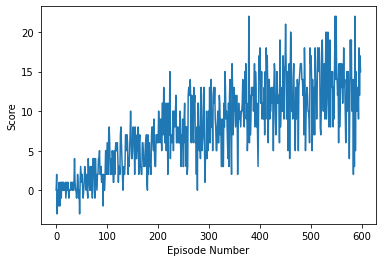

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.xlabel('Episode Number')
plt.ylabel('Score')
plt.show()


In [11]:
################################################################################
##                                                                            ##
##                    Test your network                                       ##
##                                                                            ##
################################################################################

# Just run this if you want to train your own network

import time

time.sleep(5)

env_info = env.reset(train_mode=False)[brain_name]               # Reset the Environment
state = env_info.vector_observations[0]                          # First state
score = 0                                                        # Score counter
max_t = 1000                                                     # Max step
eps = 0.2                                                        # Default espsilon, for little exploration
step = 0                                                         # Step counter

for t in range(max_t):
    action = agent.act(state, eps)                                # Choose an action
    env_info = env.step(action)[brain_name]                       # Done step
    next_state = env_info.vector_observations[0]                  # Retrieve values from the previous step
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    state = next_state
    score += reward                                                # Add new reword
    if done or step >= max_t:                                        # Stop if done or max step reach
        break
print(f"Score: {score}")

Score: 13.0


In [12]:
env.close()